<a href="https://colab.research.google.com/github/kasidejcha/net_rate/blob/main/net_rate_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
from pandas import to_datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# function for mape
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [93]:
train = pd.read_csv('/content/drive/My Drive/net_rate/Data/train.csv').drop('gmv_rate',axis=1)
val = pd.read_csv('/content/drive/My Drive/net_rate/Data/val.csv').drop('gmv_rate',axis=1)
val.tail()

,date,net_rate
25,2021-07-03,0.857004
26,2021-07-04,0.849715
27,2021-07-05,0.850116
28,2021-07-06,0.851735
29,2021-07-07,0.666483


In [94]:
# date cut
train = train[train['date']>='2020-07-01'].reset_index(drop=True)

In [95]:
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(train['net_rate'])

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

adfuller_test(train['net_rate'])

ADF Test Statistic : -11.282649980312575
p-value : 1.4434220786235808e-20
#Lags Used : 1
Number of Observations Used : 340
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


## Prophet single variable Forecasting

In [6]:
# formatting for Prophet
train_prophet = train.copy().rename(columns={'date':'ds', 'net_rate': 'y'})
train_prophet['ds'] = to_datetime(train_prophet['ds'])

In [31]:
model = Prophet()
model.fit(train_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
future = model.make_future_dataframe(periods=len(val))
future.tail()

,ds
367,2021-07-03
368,2021-07-04
369,2021-07-05
370,2021-07-06
371,2021-07-07


In [33]:
forecast1 = model.predict(future)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
367,2021-07-03,0.852815,0.802813,0.906429
368,2021-07-04,0.836731,0.782658,0.887269
369,2021-07-05,0.834270,0.782043,0.886408
370,2021-07-06,0.845007,0.794564,0.897081
371,2021-07-07,0.854581,0.801259,0.908607


In [34]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(model, forecast1)

In [35]:
result = val.copy()
result.rename(columns={'net_rate':'actual'},inplace=True)
result['forecast'] = forecast1['yhat'][-len(val):].reset_index(drop=True)
result.set_index('date',inplace=True)
result.index = to_datetime(result.index)

In [36]:
# Metrics
forecast = result.copy()
# root mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])
rmse = sqrt(mse)

# mean absolute percent error
mape = MAPE(forecast['forecast'], forecast['actual'])

# mean absolute error
mae = mean_absolute_error(forecast['forecast'], forecast['actual'])

# mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])

# median absolute error
MDAE = np.median(abs(forecast['forecast']-forecast['actual']))

# median absolute percent error
MDAPE = np.median((np.abs(np.subtract(forecast['forecast'], forecast['actual'])/ forecast['actual']))) * 100

index=['mse','rmse','mae','mape','mdae','mdape']
metrics = pd.DataFrame([mse,rmse,mae,mape,MDAE,MDAPE],columns={'metrics'})
metrics.index = index
metrics

,metrics
mse,0.002311
rmse,0.048075
mae,0.030399
mape,3.569195
mdae,0.019179
mdape,2.213200


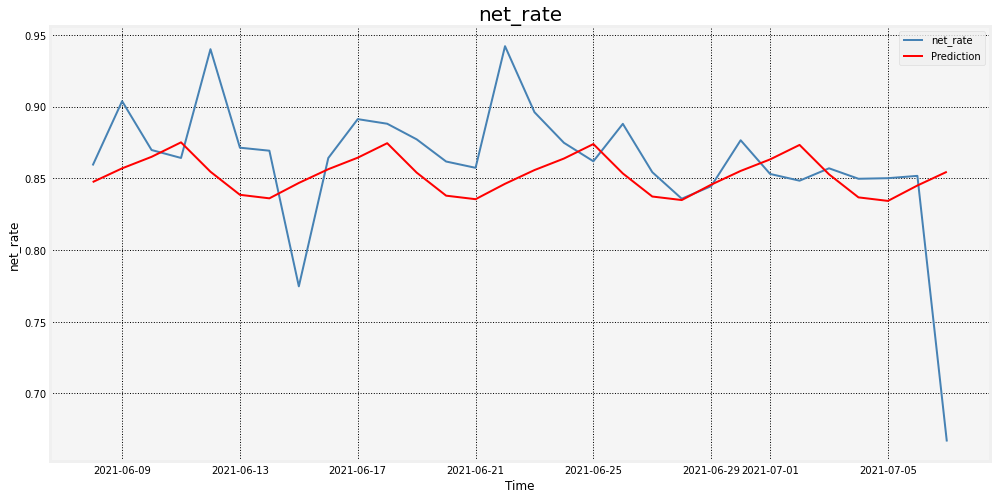

In [37]:
# Plot Data
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (15.0, 8) # set the size of figure
plt.subplot(facecolor = "whitesmoke") # set the background color
plt.plot(forecast['actual'],label = 'net_rate',color="steelblue", linestyle="-", linewidth=2.0) # plot with set the line width,shape and color
plt.plot(forecast['forecast'], label = 'Prediction', color="Red", linewidth=2.0)
plt.legend()

plt.xlabel("Time")
plt.ylabel("net_rate")
plt.title("net_rate", fontsize = 20)
plt.grid(color="k", linestyle=":") # set grid and line shape

# plt.savefig('Daily cases.png')
plt.show()

## Prophet Multivariable Forecasting

In [124]:
# feature engineering
# log return: assume that prices are distributed log normally
eng = train.copy()
eng = eng.append(val).reset_index(drop=True)
print(eng.tail())
print('total len:', len(eng))
print('train len:', len(train))
print('val len:', len(val))
# log = np.log(1+train["net_rate"])
# eng['log_netrate'] = log
# eng.head()
# https://quantivity.wordpress.com/2011/02/21/why-log-returns/

           date  net_rate
367  2021-07-03  0.857004
368  2021-07-04  0.849715
369  2021-07-05  0.850116
370  2021-07-06  0.851735
371  2021-07-07  0.666483
total len: 372
train len: 342
val len: 30


In [125]:
dday = []
for i in range(len(eng)):
    st = str(eng.date[i])
    if st[5:7] == st[8:10]:
        day = 1
        dday.append(day)
        continue
    if st[8:10] == '15':
        day = 1
        dday.append(day)
        continue
    else:
        day = 0
        dday.append(day)

eng['dday'] = dday
eng.tail()

,date,net_rate,dday
367,2021-07-03,0.857004,0
368,2021-07-04,0.849715,0
369,2021-07-05,0.850116,0
370,2021-07-06,0.851735,0
371,2021-07-07,0.666483,1


In [126]:
month = []
for i in range(len(eng)):
    st = str(eng.date[i])
    num_month = int(st[5:7])
    month.append(num_month)

eng['month'] = month
eng.tail()

,date,net_rate,dday,month
367,2021-07-03,0.857004,0,7
368,2021-07-04,0.849715,0,7
369,2021-07-05,0.850116,0,7
370,2021-07-06,0.851735,0,7
371,2021-07-07,0.666483,1,7


In [127]:
season=[]
summer = [3,4,5,6]
rain = [7,8,9,10]
winter = [11,12,1,2]

for i in range(len(eng)):
  st = str(eng.date[i])
  if int(st[5:7]) in summer:
    num_season = 0
    season.append(num_season)
    continue
  if int(st[5:7]) in rain:
    num_season = 1
    season.append(num_season)
    continue
  if int(st[5:7]) in winter:
    num_season = 2
    season.append(num_season)
    continue

eng['season'] = season
eng.tail()

,date,net_rate,dday,month,season
367,2021-07-03,0.857004,0,7,1
368,2021-07-04,0.849715,0,7,1
369,2021-07-05,0.850116,0,7,1
370,2021-07-06,0.851735,0,7,1
371,2021-07-07,0.666483,1,7,1


In [128]:
multi_eng = eng
multi_eng.rename(columns={'date':'ds','net_rate':'y'},inplace=True)
multi_eng.tail()

,ds,y,dday,month,season
367,2021-07-03,0.857004,0,7,1
368,2021-07-04,0.849715,0,7,1
369,2021-07-05,0.850116,0,7,1
370,2021-07-06,0.851735,0,7,1
371,2021-07-07,0.666483,1,7,1


In [148]:
# train & test split
multi_train = multi_eng[:-30]
multi_val = multi_eng[-30:]
multi_train.tail() #input train dataset

,ds,y,dday,month,season
337,2021-06-03,0.860099,0,6,0
338,2021-06-04,0.884038,0,6,0
339,2021-06-05,0.936399,0,6,0
340,2021-06-06,0.735210,1,6,0
341,2021-06-07,0.763073,0,6,0


In [130]:
multi_model = Prophet(interval_width=0.95)

In [131]:
multi_model.add_regressor('dday', standardize=False)
multi_model.add_regressor('month', standardize=False)
multi_model.add_regressor('season', standardize=False)

In [132]:
multi_model.fit(multi_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [133]:
multi_future = multi_model.make_future_dataframe(periods=len(multi_val))
multi_future.tail()

,ds
367,2021-07-03
368,2021-07-04
369,2021-07-05
370,2021-07-06
371,2021-07-07


In [134]:
# must know future value
multi_future['dday'] = multi_eng['dday']
multi_future['month'] = multi_eng['month']
multi_future['season'] = multi_eng['season']
multi_future.tail()

,ds,dday,month,season
367,2021-07-03,0,7,1
368,2021-07-04,0,7,1
369,2021-07-05,0,7,1
370,2021-07-06,0,7,1
371,2021-07-07,1,7,1


In [135]:
multi_forecast = multi_model.predict(multi_future)
multi_forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
367,2021-07-03,0.850732,0.779099,0.918542
368,2021-07-04,0.831767,0.763744,0.903386
369,2021-07-05,0.827693,0.754926,0.901486
370,2021-07-06,0.841296,0.774115,0.917052
371,2021-07-07,0.780843,0.709077,0.849346


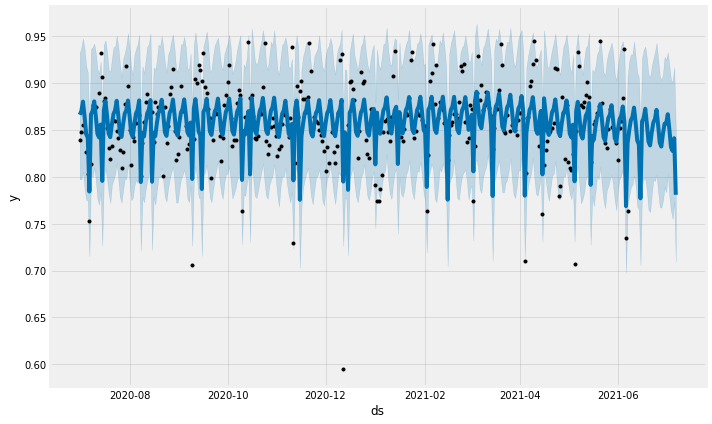

In [136]:
multi_fig = multi_model.plot(multi_forecast)

In [143]:
forecast = multi_forecast[['ds','yhat']][-30:].reset_index(drop=True)
forecast.rename(columns={'yhat':'forecast'}, inplace=True)
forecast['actual'] = val['net_rate']
forecast.set_index('ds',inplace=True)
forecast.tail()

,forecast,actual
ds,,
2021-07-03,0.850732,0.857004
2021-07-04,0.831767,0.849715
2021-07-05,0.827693,0.850116
2021-07-06,0.841296,0.851735
2021-07-07,0.780843,0.666483


In [144]:
# root mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])
rmse = sqrt(mse)

# mean absolute percent error
mape = MAPE(forecast['forecast'], forecast['actual'])

# mean absolute error
mae = mean_absolute_error(forecast['forecast'], forecast['actual'])

# mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])

# median absolute error
MDAE = np.median(abs(forecast['forecast']-forecast['actual']))

# median absolute percent error
MDAPE = np.median((np.abs(np.subtract(forecast['forecast'], forecast['actual'])/ forecast['actual']))) * 100

index=['mse','rmse','mae','mape','mdae','mdape']
metrics = pd.DataFrame([mse,rmse,mae,mape,MDAE,MDAPE],columns={'metrics'})
metrics.index = index
metrics

,metrics
mse,0.001357
rmse,0.036842
mae,0.025413
mape,3.028364
mdae,0.018230
mdape,2.147152


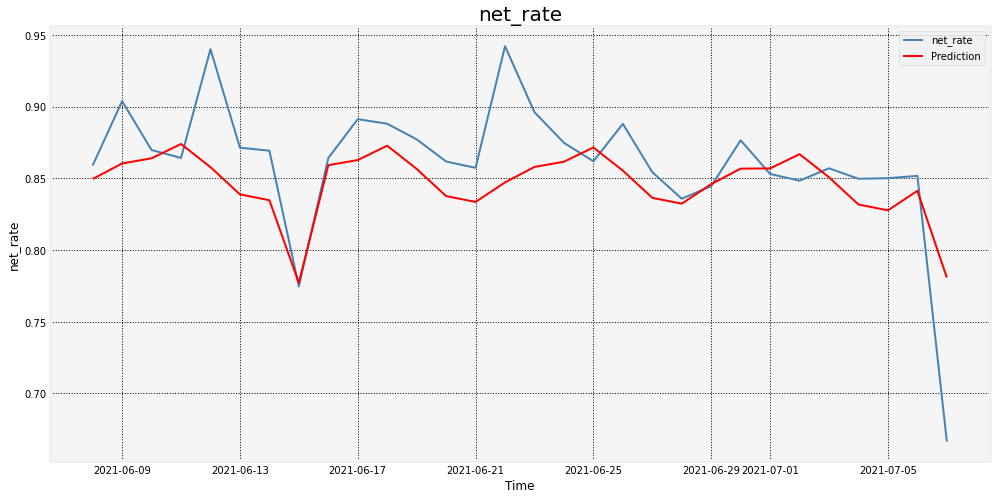

In [145]:
# Plot Data
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (15.0, 8) # set the size of figure
plt.subplot(facecolor = "whitesmoke") # set the background color
plt.plot(forecast['actual'],label = 'net_rate',color="steelblue", linestyle="-", linewidth=2.0) # plot with set the line width,shape and color
plt.plot(forecast['forecast'], label = 'Prediction', color="Red", linewidth=2.0)
plt.legend()

plt.xlabel("Time")
plt.ylabel("net_rate")
plt.title("net_rate", fontsize = 20)
plt.grid(color="k", linestyle=":") # set grid and line shape

# plt.savefig('Daily cases.png')
plt.show()